In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc



# Reading in pickle files

In [6]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

# Split frame.time into H,M,S

In [7]:
X_train['H'] = X_train['frame.time'].dt.hour
X_train['M'] = X_train['frame.time'].dt.minute
X_train['S'] = X_train['frame.time'].dt.second
X_train.drop(columns=['frame.time'], inplace=True,errors='ignore')

X_test['H'] = X_test['frame.time'].dt.hour
X_test['M'] = X_test['frame.time'].dt.minute
X_test['S'] = X_test['frame.time'].dt.second
X_test.drop(columns=['frame.time'], inplace=True,errors='ignore')

# Model

## With H,M,S from frame.time

In [8]:
# SMOTE with time
sampling_strategy = {
    0: 150000,   # Backdoor
    1: 150000,   # DDoS_HTTP
    2: 150000,   # DDoS_ICMP
    3: 150000,   # DDoS_TCP
    4: 150000,   # OS_Fingerprinting
    5: 150000,   # Password
    6: 150000,   # Port_Scanning
    7: 150000,   # Ransomware
    8: 150000,   # SQL_injection
    9: 150000,   # Uploading
    10: 150000,  # Vulnerability_scanner
    11: 150000,  # XSS
    12: 856840   # Normal 
}
smote = SMOTE(random_state=42,sampling_strategy =sampling_strategy)
X_resampled_with_time, y_resampled_with_time = smote.fit_resample(X_train, y_train)

In [9]:
# Model
DNN_with_time_model = Sequential()
DNN_with_time_model.add(Dense(units=256, input_dim=X_resampled_with_time.shape[1],activation='leaky_relu'))
DNN_with_time_model.add(Dropout(0.2))
DNN_with_time_model.add(Dense(units=128,activation='leaky_relu'))
DNN_with_time_model.add(Dropout(0.2))
DNN_with_time_model.add(Dense(units=64,activation='leaky_relu'))
DNN_with_time_model.add(LayerNormalization())
DNN_with_time_model.add(Dropout(0.2))
DNN_with_time_model.add(Dense(units=13, activation='softmax'))

DNN_with_time_model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=7,          # Number of epochs to wait after no improvement
                               restore_best_weights=True)  # Restores model to the best weights when stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=5,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

DNN_with_time_hist = DNN_with_time_model.fit(X_resampled_with_time, y_resampled_with_time, batch_size=500, epochs=100,validation_split=0.2,callbacks=[early_stopping,reduce_lr])

c:\Users\user\Desktop\DSA4266 Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9146 - loss: 0.2726 - val_accuracy: 0.7500 - val_loss: 0.8196 - learning_rate: 0.0010
Epoch 2/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9856 - loss: 0.0419 - val_accuracy: 0.7673 - val_loss: 0.5991 - learning_rate: 0.0010
Epoch 3/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9875 - loss: 0.0354 - val_accuracy: 0.7668 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 4/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9881 - loss: 0.0330 - val_accuracy: 0.7670 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 5/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9885 - loss: 0.0318 - val_accuracy: 0.7659 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 6/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9888 - loss: 0.0310 - val_accuracy: 0.7695 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 7/100
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accura

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 16s 814us/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7459
           1       1.00      1.00      1.00     44658
           2       1.00      1.00      1.00     43715
           3       1.00      1.00      1.00     42422
           4       0.97      1.00      0.98       300
           5       0.91      0.96      0.94     44242
           6       0.94      1.00      0.97      6769
           7       0.96      0.96      0.96      3278
           8       1.00      1.00      1.00     15361
           9       1.00      1.00      1.00     11290
          10       0.96      0.98      0.97     43759
          11       0.96      0.23      0.37      4775
          12       1.00      1.00      1.00    367217

    accuracy                           0.99    635245
   macro avg       0.98      0.93      0.94    635245
weighted avg       0.99      0.99      0.99    635245



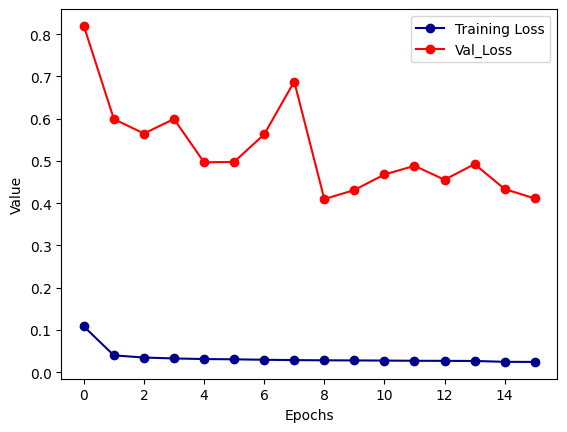

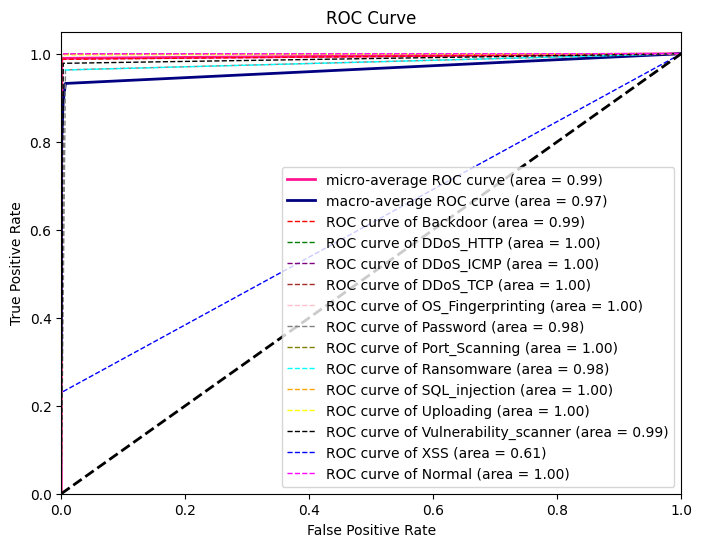

In [10]:
###################################################################################################
# Prediction
y_pred_with_time = DNN_with_time_model.predict(X_test)
y_pred_with_time = np.argmax(y_pred_with_time, axis=1)

###################################################################################################
#  Classification Report
print(classification_report(y_test, y_pred_with_time))

###################################################################################################
# Training and Validation Loss Plots
plt.plot(DNN_with_time_hist.history['loss'], label='Training Loss', marker='o', color='darkblue')
plt.plot(DNN_with_time_hist.history['val_loss'], label='Val_Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Normal': 12, 
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test, y_pred_with_time, n_classes=len(np.unique(y_test)))


## Without H,M,S from frame.time

In [11]:
# SMOTE without time
X_train_no_time = X_train.drop(columns = ['H','M','S'], errors='ignore')
X_test_no_time = X_test.drop(columns = ['H','M','S'], errors='ignore')

sampling_strategy = {
    0: 150000,   # Backdoor
    1: 150000,   # DDoS_HTTP
    2: 150000,   # DDoS_ICMP
    3: 150000,   # DDoS_TCP
    4: 150000,   # OS_Fingerprinting
    5: 150000,   # Password
    6: 150000,   # Port_Scanning
    7: 150000,   # Ransomware
    8: 150000,   # SQL_injection
    9: 150000,   # Uploading
    10: 150000,  # Vulnerability_scanner
    11: 150000,  # XSS
    12: 856840   # Normal 
}
smote_no_time = SMOTE(random_state=42,sampling_strategy =sampling_strategy)
X_resampled_no_time, y_resampled_no_time = smote_no_time.fit_resample(X_train_no_time, y_train)

In [12]:
# Model
DNN_no_time_model = Sequential()
DNN_no_time_model.add(Dense(units=256, input_dim=X_resampled_no_time.shape[1],activation='leaky_relu'))
DNN_no_time_model.add(Dropout(0.2))
DNN_no_time_model.add(Dense(units=128,activation='leaky_relu'))
DNN_no_time_model.add(Dropout(0.2))
DNN_no_time_model.add(Dense(units=64,activation='leaky_relu'))
DNN_no_time_model.add(LayerNormalization())
DNN_no_time_model.add(Dropout(0.2))
DNN_no_time_model.add(Dense(units=13, activation='softmax'))

DNN_no_time_model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=7,          # Number of epochs to wait after no improvement
                               restore_best_weights=True)  # Restores model to the best weights when stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=5,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

DNN_no_time_hist = DNN_no_time_model.fit(X_resampled_no_time, y_resampled_no_time, batch_size=500, epochs=200,validation_split=0.2,callbacks=[early_stopping,reduce_lr])

c:\Users\user\Desktop\DSA4266 Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9028 - loss: 0.2870 - val_accuracy: 0.4133 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 2/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9310 - loss: 0.1874 - val_accuracy: 0.4229 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 3/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9326 - loss: 0.1833 - val_accuracy: 0.4318 - val_loss: 1.4403 - learning_rate: 0.0010
Epoch 4/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9335 - loss: 0.1804 - val_accuracy: 0.4361 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 5/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9342 - loss: 0.1774 - val_accuracy: 0.4277 - val_loss: 1.4240 - learning_rate: 0.0010
Epoch 6/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9354 - loss: 0.1737 - val_accuracy: 0.4296 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 7/200
4251/4251 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accura

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 18s 890us/step
                       precision    recall  f1-score   support

             Backdoor       0.97      0.96      0.96      7459
            DDoS_HTTP       0.77      0.91      0.83     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      1.00      1.00     42422
    OS_Fingerprinting       0.16      0.96      0.28       300
             Password       0.66      0.83      0.73     44242
        Port_Scanning       0.96      0.93      0.95      6769
           Ransomware       0.98      0.81      0.89      3278
        SQL_injection       0.74      0.46      0.56     15361
            Uploading       0.96      0.46      0.63     11290
Vulnerability_scanner       1.00      0.89      0.94     43759
                  XSS       0.72      0.17      0.27      4775
               Normal       1.00      1.00      1.00    367217

             accuracy                           0.94    635245
     

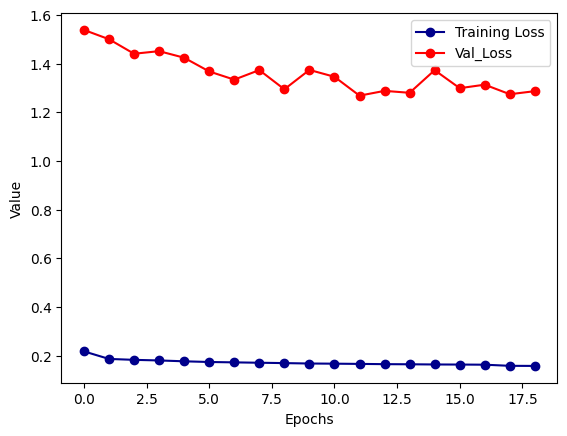

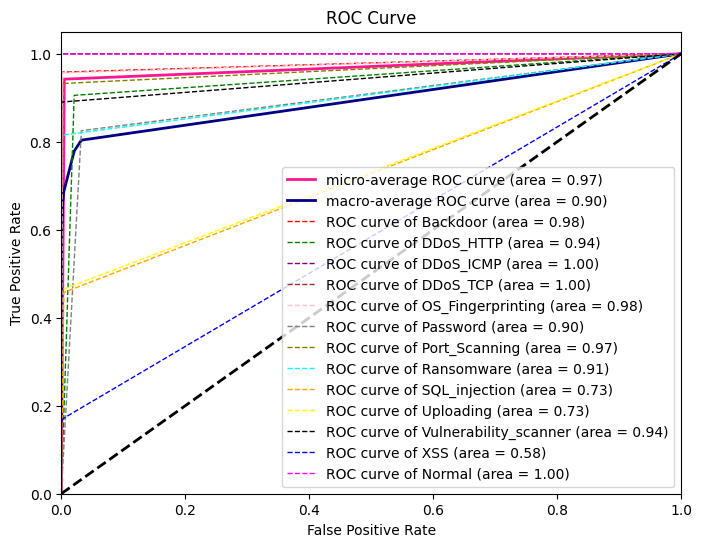

In [14]:
###################################################################################################
# Prediction
y_pred_no_time = DNN_no_time_model.predict(X_test_no_time)
y_pred_no_time = np.argmax(y_pred_no_time, axis=1)

###################################################################################################
#  Classification Report
target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS',
                'Normal']
print(classification_report(y_test, y_pred_no_time,target_names= target_names))

###################################################################################################
# Training and Validation Loss Plots
plt.plot(DNN_no_time_hist.history['loss'], label='Training Loss', marker='o', color='darkblue')
plt.plot(DNN_no_time_hist.history['val_loss'], label='Val_Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Normal': 12,
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test, y_pred_no_time, n_classes=len(np.unique(y_test)))